# ABS tutorial 04

## partial-sky ABS pipeline (with noise)

To validate the ABS method we have simulated a few foregrounds maps including dust and synchrotron at 30, 95, 150 and 353 GHz, using PySM package. CAMB is utilized to predict the CMB power spectra with respect to the Planck best fit 2018 results, from which random realizations of CMB anisotropies are obtained. For the tensor-to-scalar ratio, we set it as 0.05 for the generation of CMB maps. White noise maps are generated according to the Planck level.

Measurement uncertainties are prepared as white noise.

In [1]:
import numpy as np
import healpy as hp
import matplotlib
import abspy as ap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### read in maps

In [2]:
NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30 = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95 = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150 = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353 = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True)
map30 = hp.smoothing(map30+mapcmb,fwhm=fwhm[0])
map95 = hp.smoothing(map95+mapcmb,fwhm=fwhm[1])
map150 = hp.smoothing(map150+mapcmb,fwhm=fwhm[2])
map353 = hp.smoothing(map353+mapcmb,fwhm=fwhm[3])

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 7.643896 arcmin (0.002224 rad) 
-> fwhm is 18.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 5.095931 arcmin (0.001482 rad) 
-> fwhm is 12.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.038372 arcmin (0.000593 rad) 
-> fwhm is 4.800000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


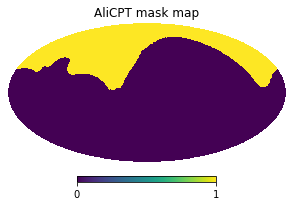

In [3]:
mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=False)

fig = matplotlib.pyplot.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='AliCPT mask map',hold=True)

CPU times: user 1min 47s, sys: 736 ms, total: 1min 47s
Wall time: 31.9 s


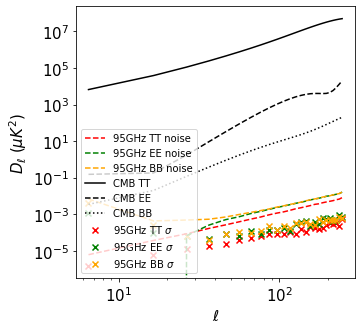

In [4]:
%%time

RESAMP = 10  # size of resampling
BINNING = 10
NPIX = 12*NSIDE**2
APOSCALE = 6.
est = ap.pstimator(nside=NSIDE, mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=BINNING)

# calculate binned CMB band-power from input Cl
cmb_dl = np.zeros((4,len(est.modes)))
cmb_dl[0] = est.modes
for i in range(len(est.modes)):
    lrange = np.array(est._b.get_ell_list(i))
    factor = 0.5*lrange*(lrange+1)/np.pi
    w = np.array(est._b.get_weight_list(i))
    for j in range(3):
        cmb_dl[j+1,i] = np.sum(w*cmb_cl[j,lrange]*factor)

n95 = np.zeros((3,NPIX,RESAMP))

for i in range(NPIX):
    for j in range(3):
        if mask[i]:
            n95[j,i,:] = np.random.normal(0,np.sqrt(vmap95[j,i]),RESAMP)
            
auto_n95 = np.zeros((3,len(est.modes)))
sigma_n95 = np.zeros((3,len(est.modes)))
for i in range(RESAMP):
    _tmp = est.auto_t(n95[0,:,i].reshape(1,-1))
    auto_n95[0] += _tmp[1]
    sigma_n95[0] += np.array(_tmp[1])*np.array(_tmp[1])
    _tmp = est.auto_eb(n95[1:,:,i].reshape(2,-1))
    auto_n95[1] += _tmp[1]
    auto_n95[2] += _tmp[2]
    sigma_n95[1] += np.array(_tmp[1])*np.array(_tmp[1])
    sigma_n95[2] += np.array(_tmp[2])*np.array(_tmp[2])
auto_n95 /= RESAMP
sigma_n95 = np.sqrt(sigma_n95/RESAMP - auto_n95**2)


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.plot(cmb_dl[0],auto_n95[0],
        color='red',linestyle='--',label='95GHz TT noise')
ax.scatter(cmb_dl[0],sigma_n95[0],
          color='red',marker='x',label='95GHz TT $\sigma$')

ax.plot(cmb_dl[0],auto_n95[1],
        color='green',linestyle='--',label='95GHz EE noise')
ax.scatter(cmb_dl[0],sigma_n95[1],
          color='green',marker='x',label='95GHz EE $\sigma$')

ax.plot(cmb_dl[0],auto_n95[2],
        color='orange',linestyle='--',label='95GHz BB noise')
ax.scatter(cmb_dl[0],sigma_n95[2],
          color='orange',marker='x',label='95GHz BB $\sigma$')

ax.plot(cmb_dl[0],cmb_dl[1]*0.5*cmb_dl[0]*(cmb_dl[0]+1)/np.pi,
        color='black',linestyle='-',label=r'CMB TT')
ax.plot(cmb_dl[0],cmb_dl[2]*0.5*cmb_dl[0]*(cmb_dl[0]+1)/np.pi,
        color='black',linestyle='--',label=r'CMB EE')
ax.plot(cmb_dl[0],cmb_dl[3]*0.5*cmb_dl[0]*(cmb_dl[0]+1)/np.pi,
        color='black',linestyle=':',label=r'CMB BB')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
#ax.set_ylim((1.e-7,1.e7))

### running ABS pipeline

- TT

In [5]:
%%time

fullmap = dict()
fullmap[0] = map30[0].reshape(1,-1)
fullmap[1] = map95[0].reshape(1,-1)
fullmap[2] = map150[0].reshape(1,-1)
fullmap[3] = map353[0].reshape(1,-1)

fullvar = dict()
fullvar[0] = vmap30[0].reshape(1,-1)
fullvar[1] = vmap95[0].reshape(1,-1)
fullvar[2] = vmap150[0].reshape(1,-1)
fullvar[3] = vmap353[0].reshape(1,-1)

pipeline1 = ap.abspipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,
                       fwhms=fwhm)
pipeline1.nsamp = RESAMP
rslt_t = pipeline1(aposcale=APOSCALE,psbin=BINNING,shift=10.,threshold=1.,verbose=True)

CPU times: user 2min 10s, sys: 1.82 s, total: 2min 11s
Wall time: 34.2 s


- EE and BB

In [6]:
%%time

fullmap.clear()
fullmap[0] = map30[1:]
fullmap[1] = map95[1:]
fullmap[2] = map150[1:]
fullmap[3] = map353[1:]

fullvar.clear()
fullvar[0] = vmap30[1:]
fullvar[1] = vmap95[1:]
fullvar[2] = vmap150[1:]
fullvar[3] = vmap353[1:]

pipeline2 = ap.abspipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,
                      fwhms=fwhm)
pipeline2.nsamp = RESAMP
rslt_eb = pipeline2(aposcale=APOSCALE,psbin=BINNING,shift=10.,threshold=1.,verbose=True)

CPU times: user 15min 59s, sys: 8.71 s, total: 16min 8s
Wall time: 4min 5s


visualize

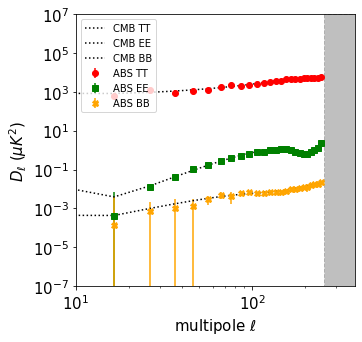

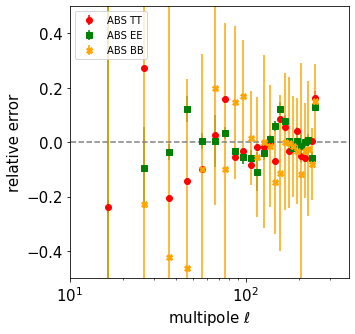

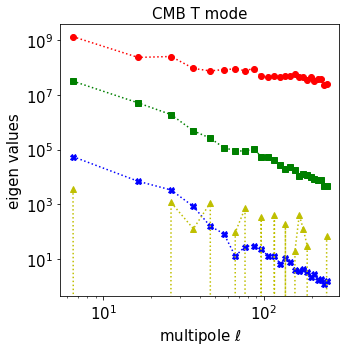

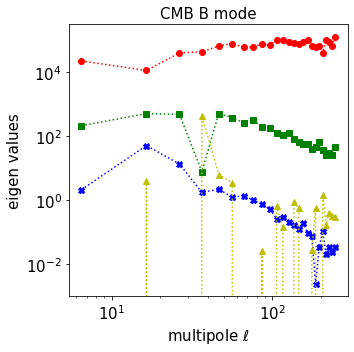

In [7]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.plot(cmb_dl[0],cmb_dl[1],color='black',linestyle=':',label=r'CMB TT')
ax.plot(cmb_dl[0],cmb_dl[2],color='black',linestyle=':',label=r'CMB EE')
ax.plot(cmb_dl[0],cmb_dl[3],color='black',linestyle=':',label=r'CMB BB')

ax.errorbar(rslt_t[0],rslt_t[1],yerr=rslt_t[2],
            color='red',fmt='o',label=r'ABS TT')
ax.errorbar(rslt_eb[0],rslt_eb[1],yerr=rslt_eb[2],
            color='green',fmt='s',label=r'ABS EE')
ax.errorbar(rslt_eb[0],rslt_eb[3],yerr=rslt_eb[4],
            color='orange',fmt='X',label=r'ABS BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((10,3*NSIDE))

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.errorbar(rslt_t[0],(rslt_t[1]-cmb_dl[1])/cmb_dl[1],yerr=rslt_t[2]/cmb_dl[1],
            color='red',fmt='o',label=r'ABS TT')
ax.errorbar(rslt_eb[0],(rslt_eb[1]-cmb_dl[2])/cmb_dl[2],yerr=rslt_eb[2]/cmb_dl[2],
            color='green',fmt='s',label=r'ABS EE')
ax.errorbar(rslt_eb[0],(rslt_eb[3]-cmb_dl[3])/cmb_dl[3],yerr=rslt_eb[4]/cmb_dl[3],
            color='orange',fmt='X',label=r'ABS BB')
ax.plot((1,3*NSIDE),(0,0),color='grey',linestyle='--')

ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'relative error',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((-0.5,0.5))
ax.set_xlim((10,3*NSIDE))

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))
freq_list = [30,95,150,353]
eigens = np.empty((len(freq_list),len(rslt_t[0])))
for i in range(eigens.shape[1]):
    eigens[:,i] = rslt_t[-1][i][0]
ax.plot(rslt_t[0],eigens[0],linestyle=':',color='r',marker='o')
ax.plot(rslt_t[0],eigens[1],linestyle=':',color='g',marker='s')
ax.plot(rslt_t[0],eigens[2],linestyle=':',color='b',marker='X')
ax.plot(rslt_t[0],eigens[3],linestyle=':',color='y',marker='^')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.set_title('CMB T mode', fontsize=15)
ax.tick_params(axis='both', labelsize=15)


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))
freq_list = [30,95,150,353]
eigens = np.empty((len(freq_list),len(rslt_eb[0])))
for i in range(eigens.shape[1]):
    eigens[:,i] = rslt_eb[-1][i][0] 
ax.plot(rslt_eb[0],eigens[0],linestyle=':',color='r',marker='o')
ax.plot(rslt_eb[0],eigens[1],linestyle=':',color='g',marker='s')
ax.plot(rslt_eb[0],eigens[2],linestyle=':',color='b',marker='X')
ax.plot(rslt_eb[0],eigens[3],linestyle=':',color='y',marker='^')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.set_title('CMB B mode', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

- only BB

In [8]:
%%time

fullmap.clear()
fullmap[0] = map30
fullmap[1] = map95
fullmap[2] = map150
fullmap[3] = map353

fullvar.clear()
fullvar[0] = vmap30
fullvar[1] = vmap95
fullvar[2] = vmap150
fullvar[3] = vmap353

pipeline3 = ap.abspipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,
                      fwhms=fwhm)
pipeline3.nsamp = RESAMP
rslt_b = pipeline3.run_bmode(aposcale=APOSCALE,psbin=BINNING,shift=10.,threshold=1.,verbose=True)

CPU times: user 21min 14s, sys: 1.87 s, total: 21min 16s
Wall time: 5min 25s


visualize

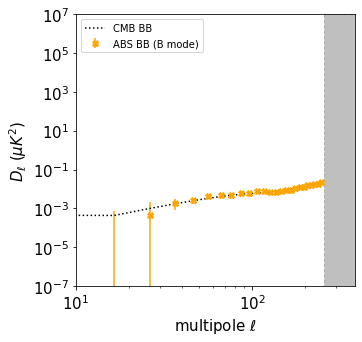

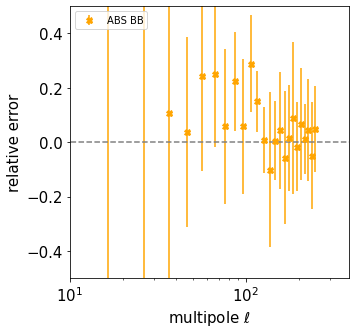

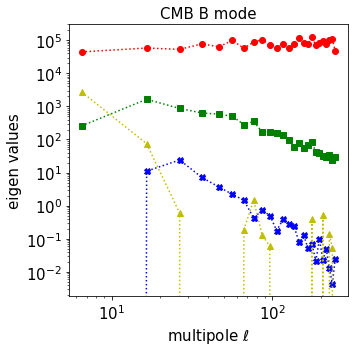

In [9]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.plot(cmb_dl[0],cmb_dl[3],color='black',linestyle=':',label=r'CMB BB')

ax.errorbar(rslt_b[0],rslt_b[1],yerr=rslt_b[2],
            color='orange',fmt='X',label=r'ABS BB (B mode)')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((10,3*NSIDE))


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.errorbar(rslt_b[0],(rslt_b[1]-cmb_dl[3])/cmb_dl[3],yerr=rslt_b[2]/cmb_dl[3],
            color='orange',fmt='X',label=r'ABS BB')
ax.plot((1,3*NSIDE),(0,0),color='grey',linestyle='--')

ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'relative error',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((-0.5,0.5))
ax.set_xlim((10,3*NSIDE))


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))
freq_list = [30,95,150,353]
eigens = np.empty((len(freq_list),len(rslt_b[0])))
for i in range(eigens.shape[1]):
    eigens[:,i] = rslt_b[-1][i][0] 
ax.plot(rslt_b[0],eigens[0],linestyle=':',color='r',marker='o')
ax.plot(rslt_b[0],eigens[1],linestyle=':',color='g',marker='s')
ax.plot(rslt_b[0],eigens[2],linestyle=':',color='b',marker='X')
ax.plot(rslt_b[0],eigens[3],linestyle=':',color='y',marker='^')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.set_title('CMB B mode', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

end